#### Imports

In [2]:
import os
import numpy as np
import skimage.io as io
import pandas as pd
from copy import deepcopy
import re
import tqdm
import matplotlib.pyplot as pltpython
from source_functions.demo import resize_image, colour_pin_mask, find_top_label
from source_functions.main import find_aligned_label
from source_functions.alignment_helper_functions import adjust_alignment
from source_functions.label_merging import align_merged_label, new_corners
from source_functions.mask_matching_functions import get_matched_masks_and_images
import cv2
import matplotlib.pyplot as plt
from skimage import measure

#### Functions

In [3]:
def get_ALICE_results(details_dict,remove_pin=False,template_option=2,use_backup=1,aligned_filter=False,backup_match_bound=0.95):
    results = find_aligned_label(
    None, # path to specific image
    details_dict, # dictionary of images and masks
    None, # pin masks (used to be put in separately)
    paths=False, # image/mask paths (used to be used instead of the dictionary with everything)
    remove_pin=remove_pin, # option to remove pin from aligned images.
    template_option=template_option, # method used for template selection in alignment process.
    ydist=True, # option to just compute distance between y coordinates durin label corner finding (find_label_corners).
    align=True, # option to align warped images to a template
    combine_extra_masks=True, # if multiple contours are found in a mask, we combine into one larger mask/contour (used for corner finding)
    template_label=None, # Option to input a specific template label so warped labels can be aligned to it.
    merge_method=0, # method 0 - median pixel, method 1 - darkest pixel selection.
    filter_imgs=True, # filter aligned image based on pixel difference between aligned label and template
    test_stages=1, # just used for testing - outputs more variables.
    use_backup=use_backup, # backup method for corner finding. If they're not great, we find closest rectangle to mask.
    aligned_filter=aligned_filter, # aditional filter for aligned images based on basic ocr (if it can find any text)
    backup_match_bound=backup_match_bound) # if alignment result isn't great, try again with a new percentage bound in alignment function.
    
    merged = results[2]
    
    try:
        aligned = align_merged_label(merged)
    except:
        try:
            aligned = adjust_alignment(merged, return_col=True) # return_col=True means the rotated image is the output.
        except:
            aligned = deepcopy(merged)
            
    # Check aligned image:
    image = cv2.cvtColor(aligned, cv2.COLOR_BGR2GRAY)
    tot_b = len(np.where(image==0)[0])
    ratio = tot_b / np.prod(np.shape(image)[:2])
    if ratio > 0.9:
        try:
            aligned = adjust_alignment(merged, return_col=True)
        except:
            aligned = deepcopy(merged)
        
    return results,aligned

In [4]:
def get_ALICE_results_simplified(details_dict,remove_pin=False,template_option=2,use_backup=1,aligned_filter=False,backup_match_bound=0.95):
    results = find_aligned_label(
    None, # path to specific image
    details_dict, # dictionary of images and masks
    paths=False, # image/mask paths (used to be used instead of the dictionary with everything)
    remove_pin=remove_pin, # option to remove pin from aligned images.
    template_option=template_option, # method used for template selection in alignment process.
    ydist=True, # option to just compute distance between y coordinates durin label corner finding (find_label_corners).
    align=True, # option to align warped images to a template
    combine_extra_masks=True, # if multiple contours are found in a mask, we combine into one larger mask/contour (used for corner finding)
    use_backup=use_backup, # backup method for corner finding. If they're not great, we find closest rectangle to mask.
    aligned_filter=aligned_filter, # aditional filter for aligned images based on basic ocr (if it can find any text)
    backup_match_bound=backup_match_bound) # if alignment result isn't great, try again with a new percentage bound in alignment function.
    
    merged = results[2]
    
    try:
        aligned = align_merged_label(merged)
    except:
        try:
            aligned = adjust_alignment(merged, return_col=True) # return_col=True means the rotated image is the output.
        except:
            aligned = deepcopy(merged)
            
    # Check aligned image:
    image = cv2.cvtColor(aligned, cv2.COLOR_BGR2GRAY)
    tot_b = len(np.where(image==0)[0])
    ratio = tot_b / np.prod(np.shape(image)[:2])
    if ratio > 0.9:
        try:
            aligned = adjust_alignment(merged, return_col=True)
        except:
            aligned = deepcopy(merged)
        
    return aligned

In [5]:
def plot_all(results,aligned,nm,details_dict,save=1,fig=0,ax=0):

    all_images, transformed, merged, orig_transformed, corners = results
    
    if save==1:
        fig,ax = plt.subplots(6,4,figsize=(12,10))

    for i,im in enumerate(all_images):
        im_ = colour_pin_mask(details_dict[i]['mask_l'],im)
        ax[0,i].imshow(im_)
        ax[1,i].imshow(im)
        ax[1,i].plot(corners[i][0],corners[i][1],'-b')
        ax[2,i].imshow(orig_transformed[i])
        ax[3,i].imshow(transformed[i])
        ax[0,i].axis('off')
        ax[1,i].axis('off')
        ax[2,i].axis('off')
        ax[3,i].axis('off')
        ax[4,i].axis('off')
        ax[5,i].axis('off')

    ax[4,0].imshow(merged)
    ax[4,0].set_title('Merged')
    ax[5,0].imshow(aligned)
    ax[5,0].set_title('Adjusted')
    
    if save == 1:
        plt.savefig(nm,dpi=600,bbox_inches='tight',pad_inches=0.025)
        plt.close('all')

#### Index Table & Paths

In [6]:
sample_pth = '/home/arias1/Documents/ALICE_Data/new_full_dataset/val'
mask_direc = '/home/arias1/Downloads/masks-20230403T135609Z-001/masks'

image_table = pd.read_csv('image_table.csv')
all_info = np.load('new_index_info.npy',allow_pickle=True)
all_info = all_info[()]

In [7]:
unq_IDs = np.unique(list(image_table['id']))

#### Example

In [82]:
id_ = '011251455'
all_images_,all_label_masks = get_matched_masks_and_images(id_,image_table, all_info, mask_direc, 
                                                           sample_pth,limit=1500,match_method=1)

In [85]:
j = 1
details_dict = {}
for i in range(0,4):
    img = all_images_[i]
    label = all_label_masks[i][j]
    details_dict.update({i: {"image": img, "mask_l": label, "mask_p": []}})
    
results,aligned = get_ALICE_results(details_dict,aligned_filter=True)

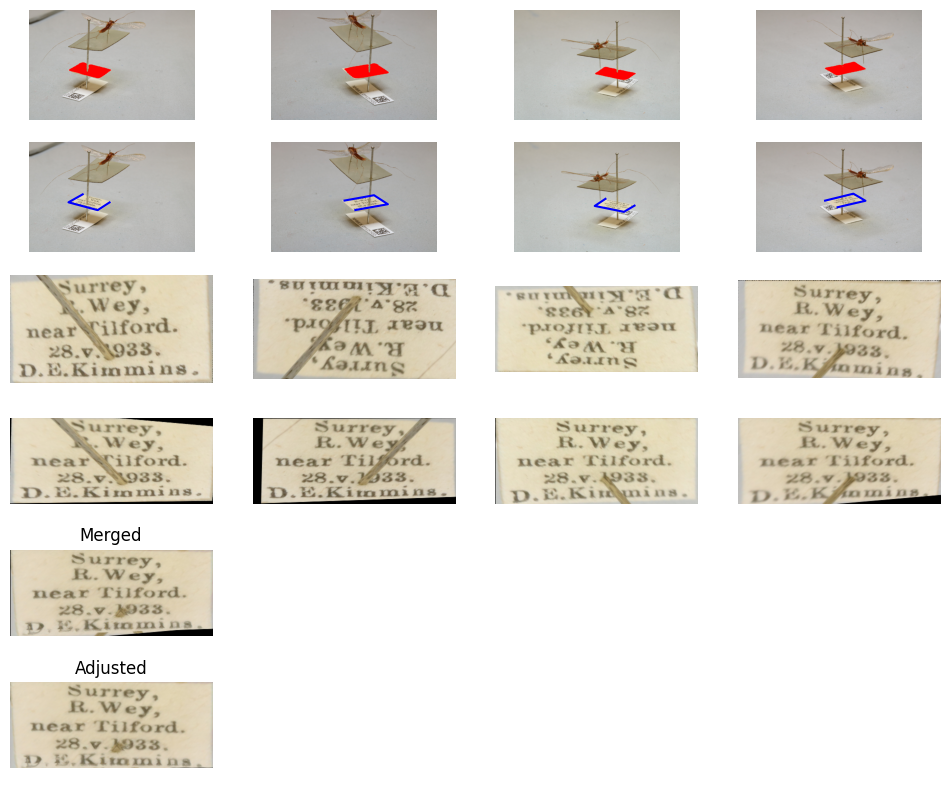

In [84]:
fig,ax = plt.subplots(6,4,figsize=(12,10))
plot_all(results,aligned,' ',details_dict,save=0,fig=fig,ax=ax)

### One function!

In [1]:
def find_all_merged_labels(id__):
    all_images,all_label_masks = get_matched_masks_and_images(id__,image_table, all_info, mask_direc, 
                                                           sample_pth,limit=1500,match_method=1)

    n = len(all_label_masks[0])
    all_merged_labels = []
    for j in range(n):
        details_dict = {}
        for i in range(0,4):
            img = all_images[i]
            label = all_label_masks[i][j]
            details_dict.update({i: {"image": img, "mask_l": label, "mask_p": []}})

        aligned_label = get_ALICE_results_simplified(details_dict,aligned_filter=True)
        all_merged_labels.append(aligned_label)
    
    return all_merged_labels, all_images[0]

In [41]:
id_ = '011244568'
labels,img = find_all_merged_labels(id_)

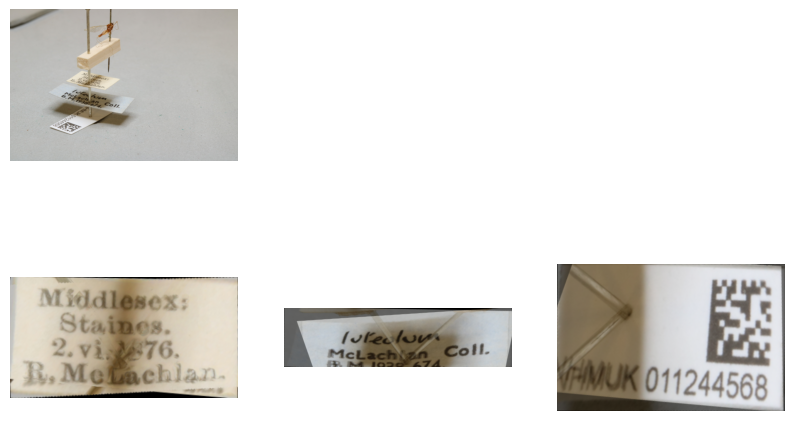

In [42]:
N = len(labels)
fig = plt.figure(figsize=(10,2*N))
ax0 = fig.add_subplot(2,N,1)
ax0.imshow(img)
ax0.axis('off')

for i,lb in enumerate(labels):
    ax = fig.add_subplot(2,N,i+N+1)
    ax.imshow(lb)
    ax.axis('off')
